In [18]:
import itertools as its
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [19]:
# Get tissue for each coefficient
inputFilename = '../data/samples_to_tissues_map.txt'
sample_file = open(inputFilename)
sample_list = np.loadtxt(sample_file,skiprows=1,usecols=[2],dtype='S40',delimiter='\t')
tissue_types = np.unique(sample_list)
sample_file.close()

# Create dataframe to count how many times each pair of tissues has non-zero coefficients on the same GO term
pair_counts = pd.DataFrame(0, index=tissue_types, columns=tissue_types)

# Get list of GO_IDs
inputFilename = '../data/GO_terms_final_gene_counts.txt'
GO_list_file = open(inputFilename)
GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
GO_list_file.close()

# Iterate through GO_ID files
for GO_ID in GO_list:
    inputFilename = '../GO_prediction/results_all_tissues/logreg_' + GO_ID + '.txt'
    results = open(inputFilename)
    nextline = 0
    for line in results:
        data = line.split()
        if nextline == 1:
            coeffs = np.array(data,dtype='float')
            results.close()
            break
        if data[1] == 'Coefficients:':
            nextline = 1
            continue
    # index of non-zero coefficients
    idx = np.where(abs(coeffs) > 0.00001)[0]

    # tissues that have non-zero coefficients
    non_zero_tissues = np.unique(sample_list[idx])
    for tissue in non_zero_tissues:
        pair_counts[tissue][tissue] = pair_counts[tissue][tissue] + 1
        
    pairs = its.combinations(non_zero_tissues,2)
    for (tissue1,tissue2) in pairs:
        pair_counts[tissue1][tissue2] = pair_counts[tissue1][tissue2] + 1
        pair_counts[tissue2][tissue1] = pair_counts[tissue2][tissue1] + 1

In [20]:
pij = pd.DataFrame(0.0, index=tissue_types, columns=tissue_types)
for tissue1 in tissue_types:
    adjusted_row_total = (sum(pair_counts[tissue1][:]) - pair_counts[tissue1][tissue1])/(2.0*len(tissue_types))
    for tissue2 in tissue_types:
        pij[tissue1][tissue2] = pair_counts[tissue1][tissue2]/adjusted_row_total

adjusted_pairs = pij + pij.transpose()

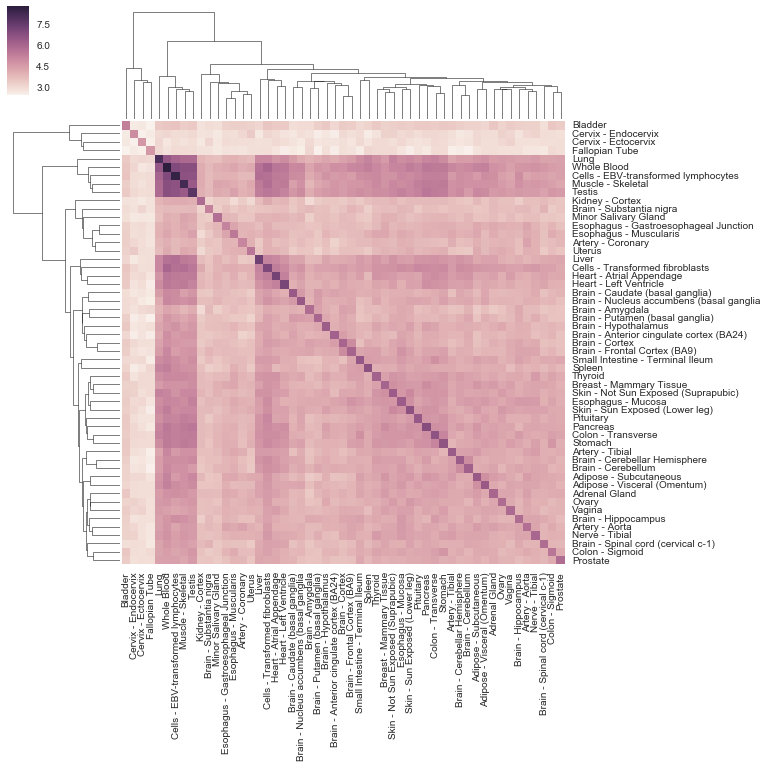

In [22]:
# Adjusted using formula
cluster = sns.clustermap(adjusted_pairs,metric='euclidean')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

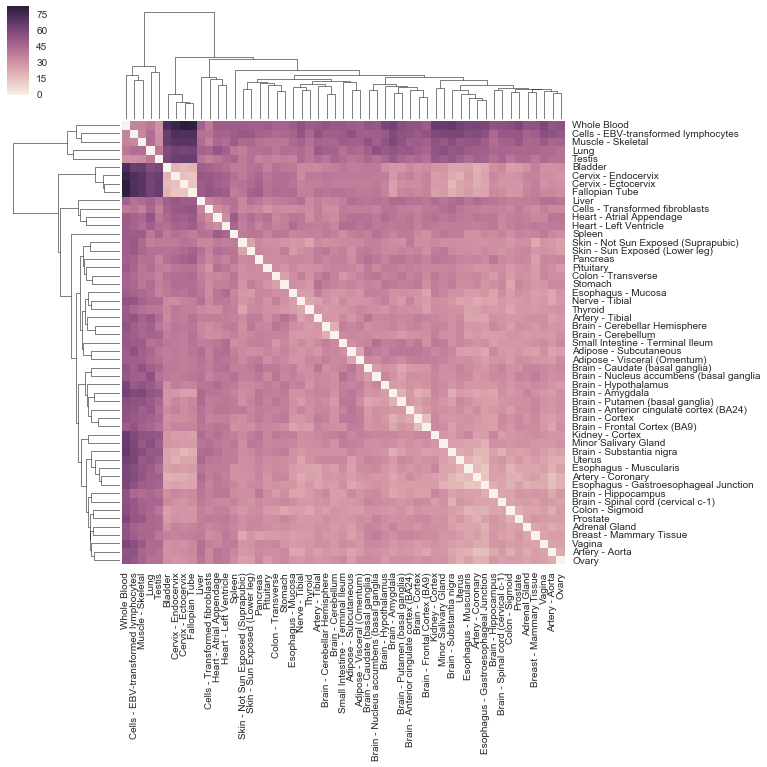

In [26]:
# subtract all values in row and all values in column by half of diagonal
diagonal_count = pd.DataFrame(0.0, index=tissue_types, columns=tissue_types)
for tissue1 in tissue_types:
    for tissue2 in tissue_types:
        diagonal_count[tissue1][tissue2] = (pair_counts[tissue1][tissue1] + pair_counts[tissue2][tissue2])/2.0
        
inv_pair_counts = diagonal_count - pair_counts

cluster = sns.clustermap(inv_pair_counts,metric='euclidean')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

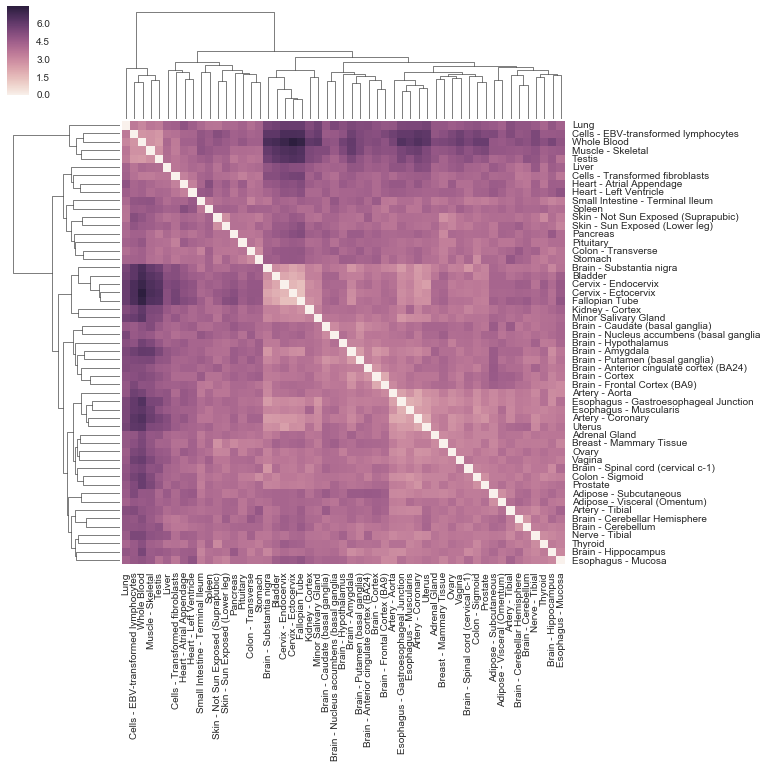

In [27]:
pij = pd.DataFrame(0.0, index=tissue_types, columns=tissue_types)
for tissue1 in tissue_types:
    adjusted_row_total = (sum(inv_pair_counts[tissue1][:]) - inv_pair_counts[tissue1][tissue1])/(2.0*len(tissue_types))
    for tissue2 in tissue_types:
        pij[tissue1][tissue2] = inv_pair_counts[tissue1][tissue2]/adjusted_row_total

adjusted_inv_pairs = pij + pij.transpose()

cluster = sns.clustermap(adjusted_inv_pairs,metric='euclidean')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()